<a href="https://colab.research.google.com/github/Molten-Ice/de-identification/blob/colab/de_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#check which GPU is being used:
!nvidia-smi

Tue May 23 16:01:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone --recurse-submodules --quiet -b colab https://github.com/Molten-Ice/de-identification
!wget -P /content/de-identification/ https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
!pip install --quiet -r ./de-identification/requirements.txt

--2023-05-23 16:01:56--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 18.160.225.53, 18.160.225.119, 18.160.225.32, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|18.160.225.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381624121 (364M) [binary/octet-stream]
Saving to: ‘/content/de-identification/ffhq.pkl’

ffhq.pkl            100%[===================>] 363.94M   219MB/s    in 1.7s    

2023-05-23 16:01:58 (219 MB/s) - ‘/content/de-identification/ffhq.pkl’ saved [381624121/381624121]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.9/205.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 90.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# Moving test image to base dir, update starting image here
!cp de-identification/media/test_image.jpg ./

#Input filename
image_filepath = 'test_image.jpg'

In [4]:
import sys
base_dir = '/content/'
sys.path.insert(1, base_dir + 'de-identification/')
from helper_functions import *

sys.path.insert(1, base_dir + 'de-identification/stylegan2-ada-pytorch')

import dnnlib
import torch_utils
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
assert device.type == "cuda", "Error, not running on gpu!"

print("Loading models, if running for first time will take a few minutes...")
with open('./de-identification/ffhq.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].to(device)  
with open('./de-identification/ffhq.pkl', 'rb') as f:
    D = pickle.load(f)['D'].to(device)
    
# First time running through sets up pluggins and takes a few minutes, after that takes < 1 second
z = torch.randn([1, G.z_dim]).to(device) # 512 latent vector                  
img = G(z, None)  # NCHW, float32, dynamic range [-1, +1], None is class labels
print("Model setup complete!")

Loading models, if running for first time will take a few minutes...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Model setup complete!


width: 552, height: 724


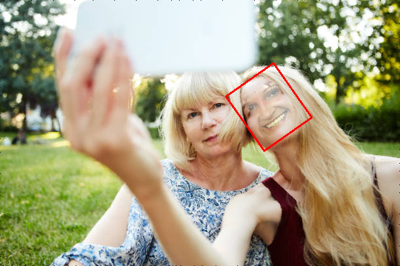

If the above image is suitable write "y" to the generated_input_attempt1.txt file, else write "n".
width: 510, height: 636


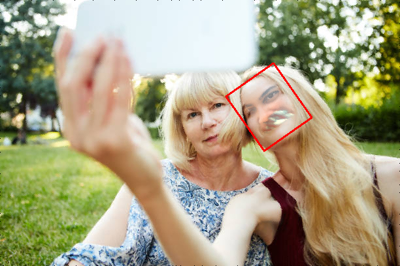

If the above image is suitable write "y" to the generated_input_attempt2.txt file, else write "n".
width: 561, height: 677


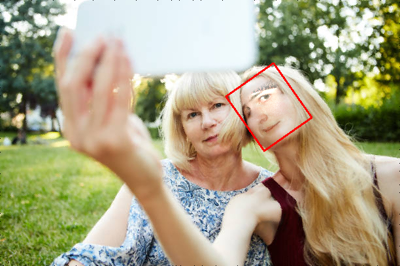

If the above image is suitable write "y" to the generated_input_attempt3.txt file, else write "n".
width: 546, height: 730


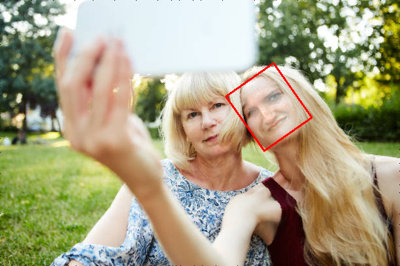

If the above image is suitable write "y" to the generated_input_attempt4.txt file, else write "n".
Losses, 0 iteration:: Complete:-0.8653, contextual:0.2156, perceptual:-1.0809 (after x0.1), time: 1.12s
Losses, 50 iteration:: Complete:-2.9739, contextual:0.2185, perceptual:-3.1924 (after x0.1), time: 4.44s
Losses, 99 iteration:: Complete:-2.9476, contextual:0.2184, perceptual:-3.1660 (after x0.1), time: 7.76s


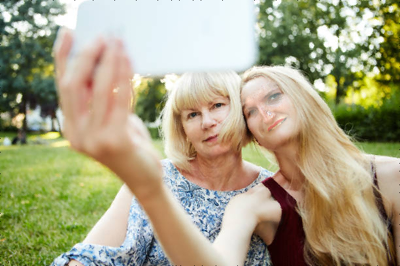

If the above image is suitable write "y" to the generated_face_attempt4.txt file, else write "n".
width: 605, height: 711


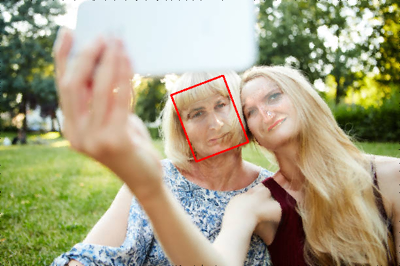

If the above image is suitable write "y" to the generated_input_attempt1.txt file, else write "n".
Losses, 0 iteration:: Complete:-2.1304, contextual:0.1516, perceptual:-2.2821 (after x0.1), time: 0.08s
Losses, 50 iteration:: Complete:-3.9334, contextual:0.1472, perceptual:-4.0806 (after x0.1), time: 3.50s
Losses, 99 iteration:: Complete:-3.2178, contextual:0.1517, perceptual:-3.3695 (after x0.1), time: 7.49s


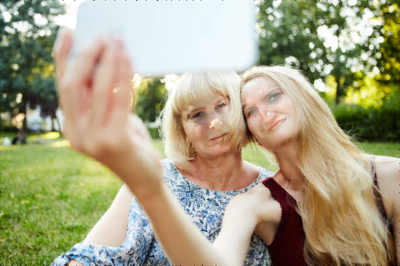

If the above image is suitable write "y" to the generated_face_attempt1.txt file, else write "n".


In [14]:
import time
def test():
    border_factor = 0.15

    !rm -rf frames
    if not os.path.exists("frames"):
        os.makedirs("frames")

    ## Loading original image ##
    original_img = cv2.imread(image_filepath)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    ## Padding image to ensure during rotation faces do not leave the image ##
    pad_width = max(original_img.shape[:2])//2
    original_img_padded = np.zeros([original_img.shape[0]+2*pad_width, original_img.shape[1]+2*pad_width, 3], dtype = original_img.dtype)
    original_img_padded[pad_width:-pad_width, pad_width:-pad_width] = original_img.copy()
    # save_image(original_img_padded, pad_width, 1)

    ## finding boxes, landmarks in original image
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    mtcnn = MTCNN(keep_all=True, device=device) # Face detection model
    original_boxes, original_landmarks, original_probs = generate_boxes_landmarks(original_img_padded, mtcnn, device)

    ### For visualization purposes - Drawing boxes on all faces ###
    annotated_faces_img = original_img_padded.copy()
    for box in original_boxes:
        cv2.rectangle(annotated_faces_img, box[:2], box[2:], (255, 0, 0), 2)
    display_image = Image.fromarray(annotated_faces_img[pad_width:-pad_width, pad_width:-pad_width])
    display_image.save(f"frames/image_{1}.jpg")
    
    frame_num = 2
    ## Looping through each face in the image ##
    for box, landmark in zip(original_boxes, original_landmarks):
        left_eye, right_eye = landmark[0], landmark[1]
        rotate_angle = calculate_rotate_angle(left_eye, right_eye)
        face_centre = [(box[0] + box[2])//2, (box[1] + box[3])//2]
        rotated_img = np.array(Image.fromarray(original_img_padded).rotate(rotate_angle, center=face_centre, expand=False))
        rotated_box = find_new_bbox_cords(mtcnn, rotated_img, face_centre, device)
        cropped_face = rotated_img[rotated_box[1]:rotated_box[3], rotated_box[0]:rotated_box[2]].copy()

        attempt = 0
        while True:
            attempt+=1

            #latent vector for synthesized face
            fixed_noise = torch.randn([1, G.z_dim]).to(device) # 512 latent vector     
            cropped_real_face_tensor, mask, box_generated, generated_face =  generate_inpainting_inputs(G, D, mtcnn, device, cropped_face, fixed_noise, border_factor = 0.15)
            blended_img_rotated = poisson_blend(generated_face, rotated_img.copy(), rotated_box)
            cv2.rectangle(blended_img_rotated, rotated_box[:2], rotated_box[2:], (255, 0, 0), 2)
            blended_img_unrotated = np.array(Image.fromarray(blended_img_rotated).rotate(-rotate_angle, center=face_centre, expand=False))
            
            

            filename = f'generated_input_attempt{attempt}.txt'
            with open(filename, 'w') as f:
                f.write("-")
            display(ImageOps.contain(Image.fromarray(blended_img_unrotated[pad_width:-pad_width, pad_width:-pad_width]), (400, 400)))
            print(f'If the above image is suitable write "y" to the {filename} file, else write "n".')
            while True:
                time.sleep(0.1)
                with open(filename, 'r') as f:
                    content = f.read()
                if content == 'y' or content == 'n':
                    break
            os.remove(filename)
            if content == 'y':
                break

        attempt = 0
        while True:
            attempt+=1
            inpainted_faces = inpaint(G, D, mtcnn, device, cropped_face, fixed_noise, cropped_real_face_tensor, mask, box_generated, lr = 0.03, iterations = 500, lam = 0.01, eval_interval = 50, border_factor = 0.15)

            #Poisson blend inpainted face onto rotated face
            blended_img = poisson_blend(inpainted_faces[-1], rotated_img.copy(), rotated_box)
            #rotate back to original orientation and set as base image
            new_original_img_padded = np.array(Image.fromarray(blended_img).rotate(-rotate_angle, center=face_centre, expand=False))
           
            filename = f'generated_face_attempt{attempt}.txt'
            with open(filename, 'w') as f:
                f.write("-")

            display(ImageOps.contain(Image.fromarray(new_original_img_padded[pad_width:-pad_width, pad_width:-pad_width]), (400, 400)))
            print(f'If the above image is suitable write "y" to the {filename} file, else write "n".')
            while True:
                time.sleep(0.1)
                with open(filename, 'r') as f:
                    content = f.read()
                if content == 'y' or content == 'n':
                    break
            os.remove(filename)
            if content == 'y':
                break

        #Visualize all progress
        images_to_save = visualize_progress(original_img_padded, box, landmark, face_centre, rotate_angle, rotated_img, rotated_box, pad_width, inpainted_faces, border_factor)
        for image in images_to_save:
            display_image = Image.fromarray(image[pad_width:-pad_width, pad_width:-pad_width])
            display_image.save(f"frames/image_{frame_num}.jpg")
            # display(ImageOps.contain(display_image, (400, 400)))
            frame_num+=1
        original_img_padded = new_original_img_padded

    
test()

In [15]:
!cd frames && ffmpeg -start_number 4 -framerate 2 -i image_%d.jpg \
  -c:v libx264 -pix_fmt yuv420p de-identification-progress.mp4
!mv frames/de-identification-progress.mp4 de-identification-progress.mp4

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e